# Convert Saved model & ONNX from checkpoint

In [ ]:
import os 
import tensorflow as tf 
from tqdm.notebook import tqdm
from models import Generator
from dataset import build_dataset,ColorizationTransforms,Mode
import scipy.stats as stats
import opt
import wandb
from typing import List
from PIL import Image

In [2]:
def log_image(
     images: List[tf.Tensor], max_image_count=8
):
    images = [
        image[:max_image_count] if len(image) > max_image_count else image
        for image in images
    ]
    images = [
        (tf.concat([image] * 3, -1) if image.shape[-1] == 1 else image)
        for image in images
    ]

    images = tf.concat(images, 1)
    image = tf.concat([image for image in images], 1)
    image = wandb.Image.to_uint8(image.numpy())
    return image

In [3]:
import cv2
import numpy as np

def create_line(path):
    line = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    line = cv2.resize(line, (128, 128),interpolation=cv2.INTER_AREA)
    line = line.astype(np.float32) / 255
    line = (line - 0.5) / 0.5
    line = np.expand_dims(line, 0)
    line = np.expand_dims(line, -1)
    return line

In [ ]:
root_dir = './DATASET'

image_size = 512
draft_image_r = 4
batch_size = 4

test_transforms = ColorizationTransforms(
    image_size, draft_image_r, train=Mode.TEST
)
dataset = build_dataset(
    os.path.join(root_dir, "test"), test_transforms, batch_size
)

mu = 1
sigma = 0.005
X = stats.truncnorm(
    (0 - mu) / sigma,
    (1 - mu) / sigma,
    loc=mu,
    scale=sigma
)
ds_itr = iter(dataset)
test_batch = next(ds_itr)
test_batch = next(ds_itr)
test_batch = next(ds_itr)
test_batch = next(ds_itr)
test_batch = next(ds_itr)
test_batch = next(ds_itr)
test_batch = next(ds_itr)
line, line_draft, hint, color = test_batch
mask = opt.mask_gen(list(hint.shape), X, 0)
hint = hint * mask
test_batch = (line, line_draft, hint, color)

# Draft Model Convert

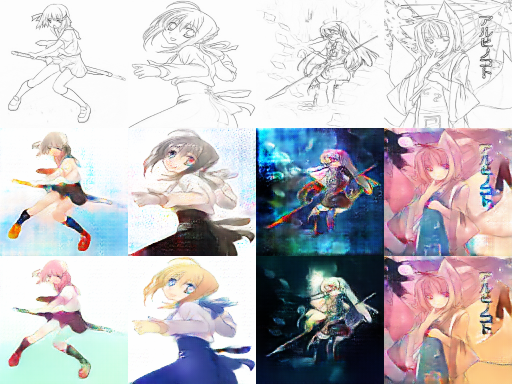

In [5]:
line, line_draft, hint, color = test_batch 
LINE_PATH = "./DATASET/test/line/16.jpg"
CKPT_PATH ='./draft.h5'
assert os.path.exists(CKPT_PATH)
draft_model =Generator(64)
draft_model({'line': line_draft, 'hint':hint})
draft_model.load_weights(CKPT_PATH)
x = draft_model({'line': line_draft, 'hint':tf.zeros_like(hint)})
w_hint = draft_model({'line': line_draft, 'hint':hint})
image = log_image([line_draft,x,w_hint])
Image.fromarray(image).show()

In [ ]:
DRAFT_SAVED_MODEL_PATH ='src/saved_model/Draft'
draft_model.save(DRAFT_SAVED_MODEL_PATH)

# Colorization Model Convert

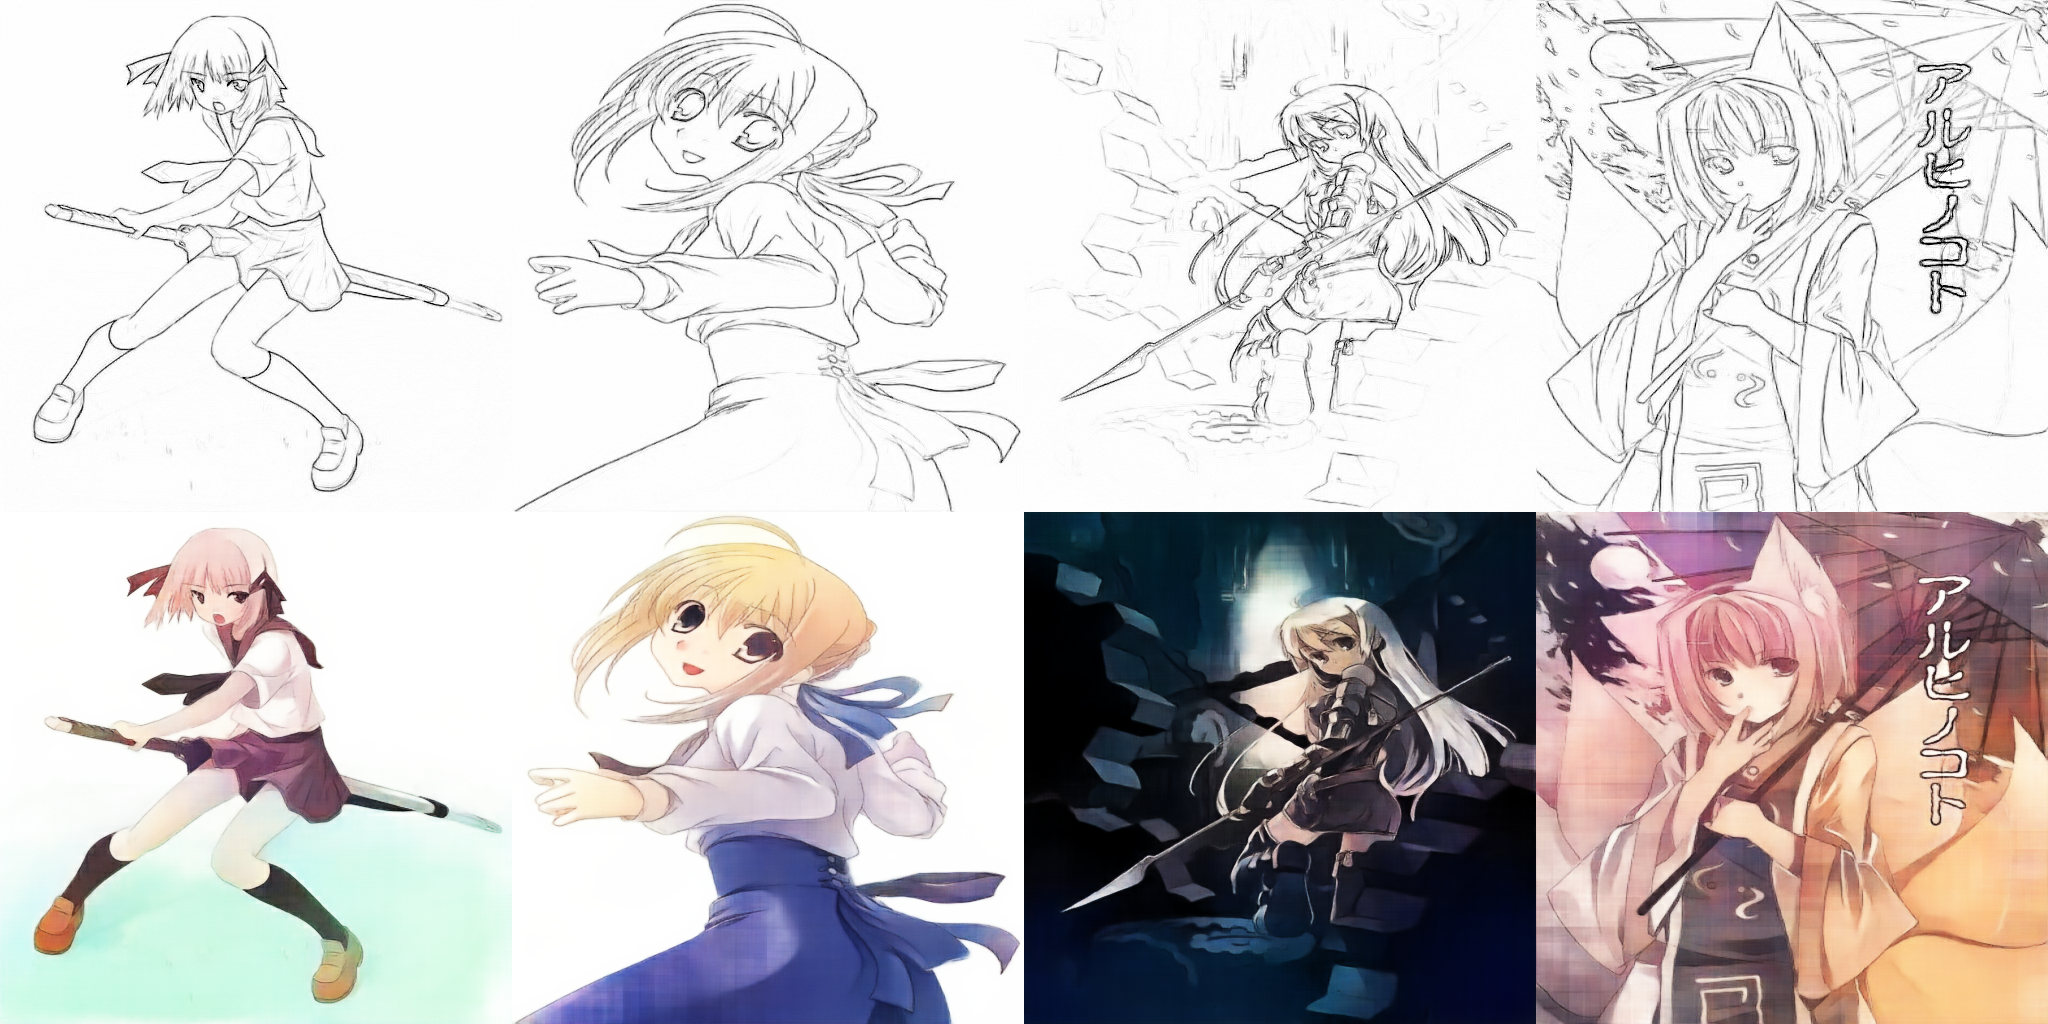

In [7]:
line, line_draft, hint, color = test_batch
color_model = Generator(64)
CKPT_PATH ='./color.h5'
draft = draft_model({"line":line_draft,"hint":hint})
draft = [image.numpy() for image in draft]
draft = [cv2.resize(image,(512,512),interpolation=cv2.INTER_NEAREST) for image in draft]
draft = [np.expand_dims(image,0) for image in draft]
draft = np.concatenate(draft,0)
draft = tf.convert_to_tensor(draft)

color_model({'line':line,"hint":draft})
color_model.load_weights(CKPT_PATH)
image = color_model({'line':line,"hint":draft})
image = log_image([line,image])
Image.fromarray(image).show()

In [ ]:
COLOR_SAVED_MODEL_PATH ='src/saved_model/Colorization'
color_model.save(COLOR_SAVED_MODEL_PATH)

In [ ]:
DRAFT_ONNX_PATH = 'src/onnx/Draft.onnx'
COLOR_ONNX_PATH = 'src/onnx/Colorization.onnx'

! python -m tf2onnx.convert --saved-model {DRAFT_SAVED_MODEL_PATH} --output {DRAFT_ONNX_PATH} --opset 13
! python -m tf2onnx.convert --saved-model {COLOR_SAVED_MODEL_PATH} --output {COLOR_ONNX_PATH} --opset 13
! ls src/onnx

# ONNXRUNTIME TEST

In [10]:
import onnxruntime
import numpy as np 
import cv2

In [11]:
draft_session = onnxruntime.InferenceSession(DRAFT_ONNX_PATH)
color_session = onnxruntime.InferenceSession(COLOR_ONNX_PATH)

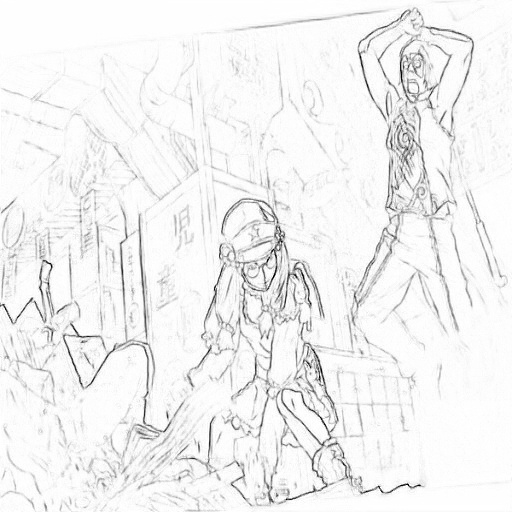

In [12]:
line = cv2.imread(LINE_PATH)
Image.fromarray(line).show()
line = cv2.cvtColor(line,cv2.COLOR_BGR2GRAY)
line_draft = cv2.resize(line,(128,128),interpolation=cv2.INTER_AREA)
line= cv2.resize(line,(512,512),interpolation=cv2.INTER_AREA)
line_draft = line_draft.astype(np.float32)/255
line_draft = (line_draft -0.5) / 0.5
line_draft = np.expand_dims(line_draft,0)
line_draft = np.expand_dims(line_draft,-1)
line= line.astype(np.float32)/255
line= (line-0.5) / 0.5
line= np.expand_dims(line,0)
line= np.expand_dims(line,-1)

hint = np.zeros([1,128,128,3],dtype=np.float32)

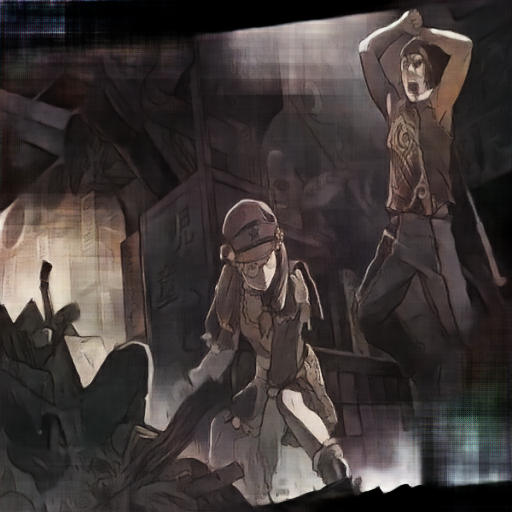

In [13]:
input_tag = draft_session.get_inputs()

draft = draft_session.run(None, {
    input_tag[1].name : line_draft,
    input_tag[0].name : hint,
})[0]

draft = cv2.resize(draft[0],dsize=(512,512),interpolation=cv2.INTER_NEAREST)
draft = np.expand_dims(draft,0)

input_tag = color_session.get_inputs()
output = color_session.run(None, {
    input_tag[1].name : line,
    input_tag[0].name : draft,
})[0]

output = output*0.5 + 0.5
output = output *255.0
output = np.clip(output,0,255)
output = output.astype(np.uint8)[0]
Image.fromarray(output).show()




# Convert PaintsTensorflow to ONNX Done

In [15]:
! ls ./src/saved_model
! ls ./src/onnx

Colorization  Draft
Colorization.onnx  Draft.onnx
